# Download Data

In [1]:
!wget -q https://hkustconnect-my.sharepoint.com/:u:/g/personal/nnanda_connect_ust_hk/EfREjZqiZTlPqhqUPICBbPABdlgPumlaUVxPncm-_9aWIw?download=1 -O "Project 1 - data.zip"
!unzip -q "Project 1 - data.zip"

# Import Libraries

In [3]:
!pip -q install keras-layer-normalization

In [46]:
import os
import nltk
import math
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import Counter
from itertools import chain
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, BatchNormalization,\
    Activation, Input, Add, Concatenate, Embedding, Conv1D, MaxPool1D,\
    Flatten, LSTM, Bidirectional, MaxPooling1D, SimpleRNN, GRU, SpatialDropout1D
from keras_layer_normalization import LayerNormalization
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pickle
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression


In [12]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [6]:
stopwords = set(stopwords.words("english"))
ps = PorterStemmer()

# Data Loader

In [7]:
def load_data(split_name='train', columns=['text', 'stars']):
    try:
        print(f"select [{', '.join(columns)}] columns from the {split_name} split")
        df = pd.read_csv(f'data_2021_spring/{split_name}.csv')
        df = df.loc[:,columns]
        print("succeed!")
        return df
    except:
        print("Failed, then try to ")
        print(f"select all columns from the {split_name} split")
        df = pd.read_csv(f'data_2021_spring/{split_name}.csv')
        return df

In [8]:
train_df = load_data('train', columns=['full'])
valid_df = load_data('valid', columns=['full'])
test_df = load_data('test', columns=['full'])

select [full] columns from the train split
Failed, then try to 
select all columns from the train split
select [full] columns from the valid split
Failed, then try to 
select all columns from the valid split
select [full] columns from the test split
Failed, then try to 
select all columns from the test split


# Following https://arxiv.org/pdf/2004.13851.pdf

In [9]:
"""
vectorizer
"""
import re
import string

from nltk import PorterStemmer, WordNetLemmatizer, sent_tokenize, wordpunct_tokenize, pos_tag
from nltk.corpus import wordnet, stopwords
from sklearn.feature_extraction.text import CountVectorizer


class YelpSentCountVectorizer(CountVectorizer):
    def __init__(self, ngram_range=(1, 1),
                 remove_nonwords=False, remove_stopwords=False,
                 stem=False, lemmatize=False, min_df=1, binary=False):
        super().__init__()
        self.punct = set(string.punctuation)
        self.ngram_range = ngram_range
        self.remove_nonwords = remove_nonwords
        self.stop_words = set(stopwords.words('english')) if remove_stopwords else set()
        self.stemmer = PorterStemmer() if stem else None
        self.lemmatizer = WordNetLemmatizer() if lemmatize else None
        self.min_df = min_df
        self.binary = binary

    def lemmatize(self, token, tag):
        tag = {
            'N': wordnet.NOUN,
            'V': wordnet.VERB,
            'R': wordnet.ADV,
            'J': wordnet.ADJ
        }.get(tag[0], wordnet.NOUN)
        return self.lemmatizer.lemmatize(token, tag)

    def stem(self, token):
        return self.stemmer.stem(token)

    def build_analyzer(self):
        # create the analyzer that will be returned by this method
        def analyser(doc):
            # Keep only words
            doc = re.sub('[^A-Za-z0-9]+', ' ', doc) if self.remove_nonwords else doc
            cleaned_tokens = []
            # Break the document into sentences
            for sent in sent_tokenize(doc):
                # Break the sentence into part of speech tagged tokens
                for token, tag in pos_tag(wordpunct_tokenize(sent)):
                    # Lower case and strip spaces
                    token = token.lower()
                    token = token.strip()
                    # If stopword, ignore token and continue
                    if token in self.stop_words:
                        continue
                    # If punctuation, continue
                    if all(char in self.punct for char in token):
                        continue
                    # Lemmatize/stem the token
                    if self.lemmatizer:
                        token = self.lemmatize(token, tag)
                    elif self.stemmer:
                        token = self.stem(token)
                    cleaned_tokens.append(token)
            # use CountVectorizer's _word_ngrams built in method to extract n-grams
            return self._word_ngrams(cleaned_tokens)

        return analyser

In [41]:
"""
visualize
"""

import matplotlib.pyplot as plt
from seaborn import heatmap
from sklearn.metrics import confusion_matrix


def confusion_heat_map(y_true, y_pred, normalize, fmt, labels):
    """Generate heat map based on a confusion matrix
    """
    conf_mat = confusion_matrix(y_true,
                                y_pred,
                                normalize=normalize)

    plt.figure(figsize=(5, 5))

    heatmap(conf_mat,
            annot=True,
            annot_kws={"size": 12},
            fmt=fmt,
            xticklabels=labels,
            yticklabels=labels,
            cbar=False)

    plt.xlabel('Predicted', fontsize=14)
    plt.ylabel('Actual', fontsize=14)
    plt.show()

In [54]:
"""
classification
"""

from sklearn import metrics


def f1_score_diff(y_true, y_pred):
    """Macro F1-score
    :param y_true: ground truth labels
    :param y_pred: predicted labels
    :return: macro f1-score
    """
    precision = metrics.precision_score(y_true, y_pred, average='macro')
    recall = metrics.recall_score(y_true, y_pred, average='macro')
    return 2.0 * precision * recall / (precision + recall)

In [57]:
"""
train_model
"""
from sklearn.pipeline import Pipeline


def evaluate_pipeline(X_train, y_train, X_test, y_test, pipeline):
    y_train_pred = pipeline.predict(X_train)
    f1_train = f1_score_diff(y_train, y_train_pred)

    y_test_pred = pipeline.predict(X_test)
    f1_test = f1_score_diff(y_test, y_test_pred)

    confusion_heat_map(y_test,
                                     y_test_pred,
                                     normalize='true',
                                     fmt='.1%',
                                     labels=set(y_test))

    return y_train_pred, y_test_pred, f1_train, f1_test


def train_and_test(X_train, y_train, X_test, y_test, classifier, vectorizer=None):
    if vectorizer:
        pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])
    else:
        pipeline = Pipeline([
            ('classifier', classifier)
        ])

    pipeline.fit(X_train, y_train)

    y_train_pred, y_test_pred, f1_train, f1_test = evaluate_pipeline(X_train, y_train, X_test, y_test, pipeline)

    return pipeline, y_train_pred, y_test_pred, f1_train, f1_test

# Data Creation

In [10]:
X_train = train_df['text'].tolist()
y_train = train_df['stars'].tolist()

In [11]:
X_test = valid_df['text'].tolist()
y_test = valid_df['stars'].tolist()

In [13]:
vect = YelpSentCountVectorizer(ngram_range=(1,2),
                                        remove_nonwords=True,
                                        remove_stopwords=True,
                                        stem=False,
                                        lemmatize=True)

In [14]:
%time cv = vect.fit(X_train)

CPU times: user 56.1 s, sys: 489 ms, total: 56.6 s
Wall time: 56.6 s


In [15]:
X_train_dtm = vect.transform(X_train)
X_test_dtm = vect.transform(X_test)

In [45]:
X_train_dtm.shape, X_test_dtm.shape

((10000, 386625), (2000, 386625))

In [68]:
# y_train.shape, y_test.shape

# SVM

In [19]:
# Grid-search for C
params = {'C' : np.logspace(-5, -2, 6)}

gscv = GridSearchCV(LinearSVC(max_iter=1000),
                    params,
                    scoring='f1_macro',
                    cv=3,
                    verbose=1,
                    n_jobs=-1)

In [20]:
gscv.fit(X_train_dtm, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    5.1s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=None, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': array([1.00000000e-05, 3.98107171e-05, 1.58489319e-04, 6.30957344e-04,
       2.51188643e-03, 1.00000000e-02])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1_macro', verbose=1)

In [21]:
print(gscv.best_params_)

{'C': 0.01}


In [22]:
model = LinearSVC(max_iter=1000,
                  C=0.01,
                  random_state=647)

In [23]:
%time model.fit(X_train_dtm, y_train)

CPU times: user 522 ms, sys: 12 ms, total: 534 ms
Wall time: 533 ms


LinearSVC(C=0.01, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=647, tol=0.0001,
          verbose=0)

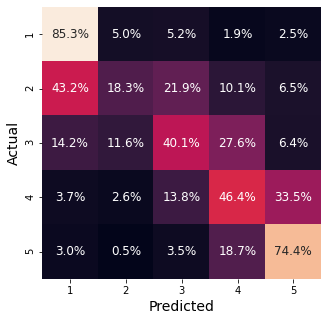

Macro F1 Scores: 
 Training: 0.989 
 Testing: 0.529




In [44]:
y_train_pred, y_test_pred, f1_train, f1_test =evaluate_pipeline(X_train = X_train_dtm,
                                                                y_train = y_train,
                                                                X_test = X_test_dtm,
                                                                y_test = y_test,
                                                                pipeline = model)

print("Macro F1 Scores: \n Training: {0:.3f} \n Testing: {1:.3f}\n\n".format(f1_train, f1_test))

SVM test (val in our case) accuracy = 52.9%

# Logistic Regression

In [47]:
# Grid-search for c
params = dict(C = np.logspace(-3, 0, 4),
              penalty = ['l1', 'l2'])

gscv = GridSearchCV(LogisticRegression(max_iter=1000,
                                       random_state=647),
                    params,
                    scoring='f1_macro',
                    cv=3,
                    verbose=1,
                    n_jobs=-1)

In [48]:
gscv.fit(X_train_dtm, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  3.8min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=1000, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=647, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': array([0.001, 0.01 , 0.1  , 1.   ]),
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1_macro', verbose=1)

In [49]:
print(gscv.best_params_)

{'C': 0.1, 'penalty': 'l2'}


In [62]:
# Final model
model = LogisticRegression(C=0.1,
                           penalty='l2',
                           max_iter=1000,
                           random_state=647,
                           n_jobs=-1)

In [63]:
%time model.fit(X_train_dtm, y_train)

CPU times: user 170 ms, sys: 26.7 ms, total: 197 ms
Wall time: 34.1 s


LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=647, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

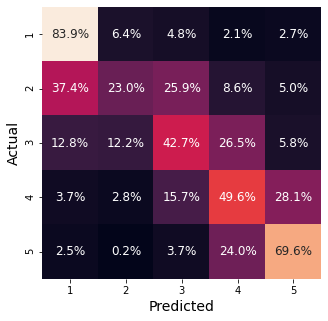

Macro F1 Scores: 
 Training: 0.991 
 Testing: 0.539




In [64]:
y_train_pred, y_test_pred, f1_train, f1_test = evaluate_pipeline(X_train = X_train_dtm,
                                                                y_train = y_train,
                                                                X_test = X_test_dtm,
                                                                y_test = y_test,
                                                                pipeline = model)

print("Macro F1 Scores: \n Training: {0:.3f} \n Testing: {1:.3f}\n\n".format(f1_train, f1_test))

# LSTM

In [70]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils.np_utils import to_categorical

print(tf.__version__)

2.4.1


In [72]:
y_train_one_hot = to_categorical(np.array(y_train)-1, num_classes=5)
y_train_one_hot.shape

(10000, 5)

In [73]:
y_test_one_hot = to_categorical(np.array(y_test)-1, num_classes=5)
y_test_one_hot.shape

(2000, 5)

In [74]:
import re
import string
import nltk
from nltk import WordNetLemmatizer, sent_tokenize, wordpunct_tokenize, pos_tag
from nltk.corpus import wordnet

In [75]:
punct = set(string.punctuation)
lemmatizer = WordNetLemmatizer()

In [77]:
def clean_doc(doc):
    cleaned_tokens = []
    # Break the document into sentences
    for sent in sent_tokenize(doc):
        # Break the sentence into part of speech tagged tokens
        for token in wordpunct_tokenize(sent):
            # Lower case and strip spaces
            token = token.lower()
            token = token.strip()
            # If punctuation, continue
            if all(char in punct for char in token):
                continue
            # Add back token
            cleaned_tokens.append(token)
    return ' '.join(cleaned_tokens)

In [78]:
X_train_clean = [clean_doc(doc) for doc in X_train]
X_test_clean = [clean_doc(doc) for doc in X_test]

In [79]:
data_train_clean = pd.DataFrame({'text':X_train_clean, 'stars':y_train})
data_train_test = pd.DataFrame({'text':X_test_clean, 'stars':y_test})

In [80]:
import urllib.request

In [81]:
urllib.request.urlretrieve('http://nlp.stanford.edu/data/glove.6B.zip', 'glove.6B.zip')

('glove.6B.zip', <http.client.HTTPMessage at 0x7fa8d9cef790>)

In [82]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [83]:
urllib.request.urlretrieve('http://nlp.stanford.edu/data/glove.twitter.27B.zip', 'glove.twitter.27B.zip')

('glove.twitter.27B.zip', <http.client.HTTPMessage at 0x7fa8da08dbd0>)

In [84]:
!unzip glove.twitter.27B.zip

Archive:  glove.twitter.27B.zip
  inflating: glove.twitter.27B.25d.txt  
  inflating: glove.twitter.27B.50d.txt  
  inflating: glove.twitter.27B.100d.txt  
  inflating: glove.twitter.27B.200d.txt  


In [85]:
tokenizer = Tokenizer()

In [86]:
%time tokenizer.fit_on_texts(X_train_clean)

CPU times: user 927 ms, sys: 9.5 ms, total: 936 ms
Wall time: 944 ms


In [87]:
word_index = tokenizer.word_index
len(word_index)

28081

In [88]:
max_length = 200

In [89]:
X_train_sequences = tokenizer.texts_to_sequences(X_train_clean)

X_train_padded = pad_sequences(X_train_sequences,
                               maxlen=max_length,
                               padding='post',
                               truncating='post')

In [90]:
X_test_sequences = tokenizer.texts_to_sequences(X_test_clean)

X_test_padded = pad_sequences(X_test_sequences,
                              maxlen=max_length,
                              padding='post',
                              truncating='post')

In [91]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_article(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print('---')
print(X_train[1])
print('---')
print(X_train_clean[1])
print('---')
print((X_train_padded[1]))
print('---')
print(decode_article(X_train_padded[1]))

---
Tried this a while back, got the fried chicken sandwich and it was meh. It was pretty small and lacked the spices and flavors I was expecting in a chicken sandwich. It's nothing special. In my opinion, Mary Browns and KFC's chicken sandwiches are better.

It took SUPER long to get 1 sandwich, there was no one even in the store and it was about 7pm. Took a good 15-20 minutes for the sandwich, no combo. The cashier was on her phone the whole time too, not really updating me about my order.
---
tried this a while back got the fried chicken sandwich and it was meh it was pretty small and lacked the spices and flavors i was expecting in a chicken sandwich it s nothing special in my opinion mary browns and kfc s chicken sandwiches are better it took super long to get 1 sandwich there was no one even in the store and it was about 7pm took a good 15 20 minutes for the sandwich no combo the cashier was on her phone the whole time too not really updating me about my order
---
[ 207   16    5

In [92]:
# embeddings_index = dict()

# with open('glove.6B.200d.txt') as f:
#   for line in f:
#     values = line.split()
#     word = values[0]
#     coefs = np.asarray(values[1:], dtype='float32')
#     embeddings_index[word] = coefs

In [123]:
# embeddings_matrix = np.zeros((len(word_index), max_length))

# for word, i in word_index.items():
#   embedding_vector = embeddings_index.get(word)
#   if embedding_vector is not None:
#     # print(embedding_vector.shape)
#     embeddings_matrix[i] = embedding_vector

In [124]:
# embeddings_matrix.shape

(28081, 200)

In [127]:
path_to_glove_file = os.path.join(
    "glove.6B.200d.txt"
)

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [128]:
num_tokens = len(word_index) + 2
embedding_dim = 200
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        # print(word)
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 24012 words (4069 misses)


In [134]:
len(word_index)

28081

In [94]:
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

BaseException: ignored

In [129]:
print((X_train_padded.shape, y_train_one_hot.shape, X_test_padded.shape, y_test_one_hot.shape))

((10000, 200), (10000, 5), (2000, 200), (2000, 5))


In [152]:
model = tf.keras.Sequential([
      # GloVe embedding
      tf.keras.layers.Input(shape=(200,)),
      tf.keras.layers.Embedding(input_dim=len(word_index)+2,
                                output_dim=max_length,
                                input_length=max_length,
                                weights=[embedding_matrix],
                                trainable=False),
      # Bidirectional LSTM
      # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=128,
      #                                                    dropout=0.3,
      #                                                    recurrent_dropout=0.3)),
      tf.keras.layers.LSTM(units=64, return_sequences=True, recurrent_dropout=0.5),
      tf.keras.layers.Dropout(rate=0.5),
      tf.keras.layers.LSTM(units=64, recurrent_dropout=0.5),
      # ReLU
      tf.keras.layers.Dense(64, activation='relu'),
      # SoftMax output
      tf.keras.layers.Dense(5, activation='softmax')
  ])


model.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.01,
                                                   decay=0.001),
                metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss',
                     mode='min',
                     verbose=1,
                     patience=2)

model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_25 (Embedding)     (None, 200, 200)          5616600   
_________________________________________________________________
lstm_45 (LSTM)               (None, 200, 64)           67840     
_________________________________________________________________
dropout_20 (Dropout)         (None, 200, 64)           0         
_________________________________________________________________
lstm_46 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_51 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_52 (Dense)             (None, 5)                 325       
Total params: 5,721,949
Trainable params: 105,349
Non-trainable params: 5,616,600
_____________________________________

In [153]:
history = model.fit(X_train_padded,
                    y_train_one_hot,
                    epochs=30,
                    # validation_data=(X_test_padded, y_test_one_hot),
                    validation_split=0.2,
                    verbose=2,
                    callbacks=[es])

Epoch 1/30
250/250 - 122s - loss: 1.5883 - accuracy: 0.2477 - val_loss: 1.5804 - val_accuracy: 0.2495
Epoch 2/30
250/250 - 119s - loss: 1.5631 - accuracy: 0.2771 - val_loss: 1.5799 - val_accuracy: 0.3095
Epoch 3/30
250/250 - 119s - loss: 1.5184 - accuracy: 0.3293 - val_loss: 1.4765 - val_accuracy: 0.3650
Epoch 4/30
250/250 - 118s - loss: 1.3073 - accuracy: 0.4300 - val_loss: 1.1881 - val_accuracy: 0.4795
Epoch 5/30
250/250 - 119s - loss: 1.1709 - accuracy: 0.4929 - val_loss: 1.1493 - val_accuracy: 0.4940
Epoch 6/30
Epoch 7/30
250/250 - 119s - loss: 1.0383 - accuracy: 0.5501 - val_loss: 1.0696 - val_accuracy: 0.5510
Epoch 8/30
250/250 - 119s - loss: 0.9909 - accuracy: 0.5749 - val_loss: 1.0546 - val_accuracy: 0.5525
Epoch 9/30
250/250 - 118s - loss: 0.9680 - accuracy: 0.5844 - val_loss: 1.0441 - val_accuracy: 0.5505
Epoch 10/30
250/250 - 118s - loss: 0.9302 - accuracy: 0.6041 - val_loss: 1.0689 - val_accuracy: 0.5425
Epoch 11/30
250/250 - 118s - loss: 0.9052 - accuracy: 0.6122 - val_los

In [154]:
accr = model.evaluate(X_test_padded, y_test_one_hot)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

63/63 [==============================] - 6s 93ms/step - loss: 1.0283 - accuracy: 0.5775
Test set
  Loss: 1.028
  Accuracy: 0.577


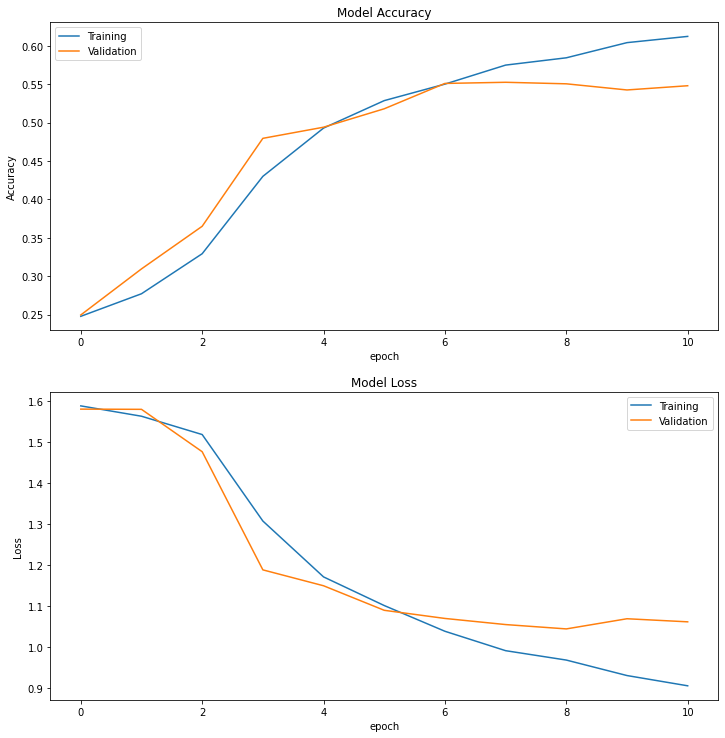

In [155]:
def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('Model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['Training', 'Validation'])

plt.subplots(figsize=(10,10))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'Accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'Loss', 212)

Try BERT